# 3章：word2vec

## 3.3 学習データの準備

### 3.3.1 コンテキストとターゲット

In [8]:
import sys
import numpy as np
sys.path.append('..')
from common.util import preprocess

text = 'You say goodbye and I say hello.'

corpus, word_to_id, id_to_word = preprocess(text)

In [9]:
print(corpus)

[0 1 2 3 4 1 5 6]


In [10]:
print(id_to_word)

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [11]:
def create_contexts_target(corpus, window_size=1):
    '''コンテキストとターゲットの作成

    :param corpus: コーパス（単語IDのリスト）
    :param window_size: ウィンドウサイズ（ウィンドウサイズが1のときは、単語の左右1単語がコンテキスト）
    :return:
    '''
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)

In [14]:
context, target = create_contexts_target(corpus, window_size=1)

In [15]:
print(context)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]


In [16]:
print(target)

[1 2 3 4 1 5]


### 3.3.2 one-hot表現への変換

In [22]:
import sys
import numpy as np
sys.path.append('..')
from common.util import preprocess, create_contexts_target, convert_one_hot

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id) # vocab_size:語彙数
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [23]:
print(contexts)

[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


In [24]:
print(target)

[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]


## 3.4 CBOWモデルの実装

In [25]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # レイヤの生成
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # すべての重みと勾配をリストにまとめる
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

### 3.4.1 学習コードの実装

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

| epoch 189 |  iter 1 / 2 | time 0[s] | loss 1.35
| epoch 190 |  iter 1 / 2 | time 0[s] | loss 1.29
| epoch 191 |  iter 1 / 2 | time 0[s] | loss 1.28
| epoch 192 |  iter 1 / 2 | time 0[s] | loss 1.29
| epoch 193 |  iter 1 / 2 | time 0[s] | loss 1.32
| epoch 194 |  iter 1 / 2 | time 0[s] | loss 1.23
| epoch 195 |  iter 1 / 2 | time 0[s] | loss 1.18
| epoch 196 |  iter 1 / 2 | time 0[s] | loss 1.35
| epoch 197 |  iter 1 / 2 | time 0[s] | loss 1.31
| epoch 198 |  iter 1 / 2 | time 0[s] | loss 1.14
| epoch 199 |  iter 1 / 2 | time 0[s] | loss 1.29
| epoch 200 |  iter 1 / 2 | time 0[s] | loss 1.18
| epoch 201 |  iter 1 / 2 | time 0[s] | loss 1.31
| epoch 202 |  iter 1 / 2 | time 0[s] | loss 1.32
| epoch 203 |  iter 1 / 2 | time 0[s] | loss 1.17
| epoch 204 |  iter 1 / 2 | time 0[s] | loss 1.21
| epoch 205 |  iter 1 / 2 | time 0[s] | loss 1.23
| epoch 206 |  iter 1 / 2 | time 0[s] | loss 1.24
| epoch 207 |  iter 1 / 2 | time 0[s] | loss 1.14
| epoch 208 |  iter 1 / 2 | time 0[s] | loss 1.30


| epoch 533 |  iter 1 / 2 | time 0[s] | loss 0.58
| epoch 534 |  iter 1 / 2 | time 0[s] | loss 0.81
| epoch 535 |  iter 1 / 2 | time 0[s] | loss 0.65
| epoch 536 |  iter 1 / 2 | time 0[s] | loss 0.81
| epoch 537 |  iter 1 / 2 | time 0[s] | loss 0.86
| epoch 538 |  iter 1 / 2 | time 0[s] | loss 0.65
| epoch 539 |  iter 1 / 2 | time 0[s] | loss 0.66
| epoch 540 |  iter 1 / 2 | time 0[s] | loss 0.74
| epoch 541 |  iter 1 / 2 | time 0[s] | loss 0.73
| epoch 542 |  iter 1 / 2 | time 0[s] | loss 0.73
| epoch 543 |  iter 1 / 2 | time 0[s] | loss 0.73
| epoch 544 |  iter 1 / 2 | time 0[s] | loss 0.85
| epoch 545 |  iter 1 / 2 | time 0[s] | loss 0.60
| epoch 546 |  iter 1 / 2 | time 0[s] | loss 0.79
| epoch 547 |  iter 1 / 2 | time 0[s] | loss 0.86
| epoch 548 |  iter 1 / 2 | time 0[s] | loss 0.53
| epoch 549 |  iter 1 / 2 | time 0[s] | loss 0.65
| epoch 550 |  iter 1 / 2 | time 0[s] | loss 0.80
| epoch 551 |  iter 1 / 2 | time 0[s] | loss 0.77
| epoch 552 |  iter 1 / 2 | time 0[s] | loss 0.72


| epoch 865 |  iter 1 / 2 | time 1[s] | loss 0.57
| epoch 866 |  iter 1 / 2 | time 1[s] | loss 0.53
| epoch 867 |  iter 1 / 2 | time 1[s] | loss 0.64
| epoch 868 |  iter 1 / 2 | time 1[s] | loss 0.50
| epoch 869 |  iter 1 / 2 | time 1[s] | loss 0.70
| epoch 870 |  iter 1 / 2 | time 1[s] | loss 0.60
| epoch 871 |  iter 1 / 2 | time 1[s] | loss 0.67
| epoch 872 |  iter 1 / 2 | time 1[s] | loss 0.67
| epoch 873 |  iter 1 / 2 | time 1[s] | loss 0.46
| epoch 874 |  iter 1 / 2 | time 1[s] | loss 0.57
| epoch 875 |  iter 1 / 2 | time 1[s] | loss 0.60
| epoch 876 |  iter 1 / 2 | time 1[s] | loss 0.67
| epoch 877 |  iter 1 / 2 | time 1[s] | loss 0.60
| epoch 878 |  iter 1 / 2 | time 1[s] | loss 0.63
| epoch 879 |  iter 1 / 2 | time 1[s] | loss 0.43
| epoch 880 |  iter 1 / 2 | time 1[s] | loss 0.77
| epoch 881 |  iter 1 / 2 | time 1[s] | loss 0.60
| epoch 882 |  iter 1 / 2 | time 1[s] | loss 0.60
| epoch 883 |  iter 1 / 2 | time 1[s] | loss 0.43
| epoch 884 |  iter 1 / 2 | time 1[s] | loss 0.67


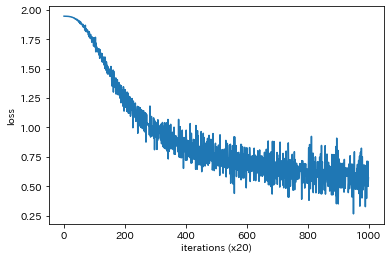

you [ 1.0243497 -1.0931704 -1.0749698 -1.3017026 -1.2601061]
say [-1.167387    1.1571164   1.0764778  -0.16702203  1.171268  ]
goodbye [ 0.8398779 -0.7346889 -0.8610927 -0.6771177 -0.5390035]
and [-0.859292   0.9345709  0.261587  -1.9325792  0.899332 ]
i [ 0.84447026 -0.74420285 -0.8943716  -0.6830332  -0.5143637 ]
hello [ 1.0320042 -1.0892807 -1.0953948 -1.2997534 -1.2568167]
. [-1.1474639  1.1306957  1.2426437  1.6250091  1.1114326]


In [26]:
import sys
sys.path.append('..')  # 親ディレクトリのファイルをインポートするための設定
from common.trainer import Trainer
from common.optimizer import Adam
from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot


window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])


## 3.5 word2vecに関する細く

### 3.5.2 skip-gramモデル

In [27]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # レイヤの生成
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()

        # すべての重みと勾配をリストにまとめる
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2
        return loss

    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        return None